# IMPORTS

In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import visdom
import numpy as np
import torch
import torchvision



c:\Users\anike\anaconda3\envs\data-science\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# import json
# from tqdm import tqdm
# import torchvision.datasets as datasets
# from torchvision.transforms import Compose, ToTensor, Resize, Normalize, transforms
# from transformers import BertTokenizer, BertModel, BertConfig

# HYPER

In [129]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1000

# DATA LOADER

In [130]:
# DEFINE CUSTOM CLASS
class ImgDataset(Dataset):
    def __init__(self, img_dir):
        self.dir = img_dir
        
        self.imgs_name = []
        for img_name in os.listdir(self.dir + "clean"):
            self.imgs_name.append(img_name)
    
    def __getitem__(self, i):

        clean = Image.open(self.dir + "clean/" + self.imgs_name[i])
        noisy = Image.open(self.dir + "noisy/" + self.imgs_name[i])
                    
        clean = ToTensor()(clean)
        noisy = ToTensor()(noisy)

        return noisy, clean
            
    def __len__(self):
        return len(self.imgs_name)

In [131]:
train_dataset = ImgDataset("train/")

In [132]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

# TESTING

In [8]:
for X, y in train_loader:
    break

In [9]:
X.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 3, 224, 224]))

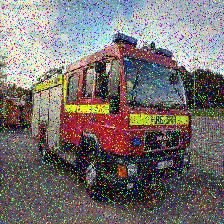

In [10]:
transforms.ToPILImage()(X[0])


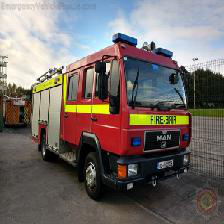

In [11]:
transforms.ToPILImage()(y[0])

# MODEL

## ENCODER

In [133]:
class Encoder(nn.Module):
    def __init__(self, features_d):
        super(Encoder, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 224 x 224
            self._enc_block(in_channels=3, out_channels=features_d, kernel_size=3, stride=2, padding=1),
            self._enc_block(in_channels=features_d, out_channels=features_d*2, kernel_size=3, stride=2, padding=1),
            self._enc_block(in_channels=features_d*2, out_channels=features_d*4, kernel_size=3, stride=2, padding=1),

            self._dec_block(in_channels=features_d*4, out_channels=features_d*2, kernel_size=3, stride=1, padding=1),
            self._dec_block(in_channels=features_d*2, out_channels=features_d, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(features_d, 3, kernel_size=3, stride=1, padding=1, bias=False,),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

    def _enc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def _dec_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, imgs):
        x = self.disc(imgs)
        return x

In [134]:
Encoder(8)(X).shape

torch.Size([64, 3, 224, 224])

## INITIALIZER

In [135]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

# TRAINING

In [136]:
enc = Encoder(8).to(device)
# dec = Decoder(256).to(device)
initialize_weights(enc)
# initialize_weights(dec)

# initializate optimizer
opt_enc = optim.Adam(enc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
# opt_dec = optim.Adam(dec.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

criterion = nn.MSELoss()

# for plotting
vis = visdom.Visdom(env="GAN_Training")
image_grid_plot = vis.image(np.random.rand(3, 32, 32).astype(np.float32))  # Placeholder for image grid

enc.train()
# dec.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (noisy, clean) in enumerate(train_loader):
        encoding = enc(noisy.to(device))
        # generated = dec(encoding)
        
        # Calculate the loss
        # loss = criterion(generated, clean.to(device))
        loss = criterion(encoding, clean.to(device))

        # Zero the gradients, perform a backward pass, and update the weights
        opt_enc.zero_grad()
        # opt_dec.zero_grad()
        loss.backward()
        opt_enc.step()
        # opt_dec.step()

        # # Print losses occasionally and print to tensorboard
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)} Loss: {loss}")

        with torch.no_grad():
            encoding = enc(noisy.to(device))
            # generated = dec(encoding)
            # Create image grids for visualization
            n = torchvision.utils.make_grid(noisy[:8].cpu(), normalize=True)
            # c = torchvision.utils.make_grid(generated[:8].cpu(), normalize=True)
            c = torchvision.utils.make_grid(encoding[:8].cpu(), normalize=True)
            # Concatenate real and fake image grids vertically for visualization
            combined_grid = torch.cat((n, c), dim=1)
            # Send the combined grid to Visdom for visualization
            vis.image(combined_grid.cpu().numpy(), win=image_grid_plot)

Setting up a new session...


Epoch [0/1000] Batch 0/16 Loss: 0.08486942946910858
Epoch [0/1000] Batch 1/16 Loss: 0.08111542463302612
Epoch [0/1000] Batch 2/16 Loss: 0.0823725238442421
Epoch [0/1000] Batch 3/16 Loss: 0.08199094980955124
Epoch [0/1000] Batch 4/16 Loss: 0.08064156770706177
Epoch [0/1000] Batch 5/16 Loss: 0.07965134084224701
Epoch [0/1000] Batch 6/16 Loss: 0.07976172119379044
Epoch [0/1000] Batch 7/16 Loss: 0.08072702586650848
Epoch [0/1000] Batch 8/16 Loss: 0.0820062905550003
Epoch [0/1000] Batch 9/16 Loss: 0.07906250655651093
Epoch [0/1000] Batch 10/16 Loss: 0.08163852989673615
Epoch [0/1000] Batch 11/16 Loss: 0.07967904955148697
Epoch [0/1000] Batch 12/16 Loss: 0.08013441413640976
Epoch [0/1000] Batch 13/16 Loss: 0.07986212521791458
Epoch [0/1000] Batch 14/16 Loss: 0.07901370525360107
Epoch [0/1000] Batch 15/16 Loss: 0.0778331309556961
Epoch [1/1000] Batch 0/16 Loss: 0.07907573878765106
Epoch [1/1000] Batch 1/16 Loss: 0.07573676109313965
Epoch [1/1000] Batch 2/16 Loss: 0.07747185230255127
Epoch [1/

KeyboardInterrupt: 

In [137]:
vis.close()

''

In [148]:
torch.save(enc, 'model.pth')

# TEST

In [139]:
loaded_model = torch.load('model.pth')

In [145]:
i = 2

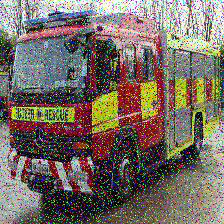

In [146]:
transforms.ToPILImage()(X[i])

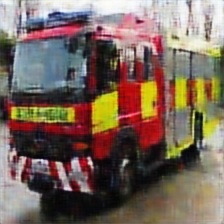

In [147]:
pred = loaded_model(X.cuda())
transforms.ToPILImage()(pred[2])


In [9]:
import mlflow
import pandas as pd

In [10]:
experiment_name = "Image Denoising"
mlflow.set_tracking_uri("sqlite:///../mlflow.db")


In [31]:
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
df = pd.DataFrame(mlflow.search_runs(experiment_ids=experiment_id))
# df = df[df["status"] == "FINISHED"]
# df = df[df["metrics.Test MSE"] == df["metrics.Test MSE"].min()]
# run_id = df["run_id"].values
# artifact_uri = df["artifact_uri"].values
# src = f"{artifact_uri[0]}/{run_id[0]}/data/model.pth"
# dest = "saved_models/model.pth"
# shutil.copyfile(src, dest)

In [32]:
df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Test MSE,metrics.Train MSE,metrics.MSE,params.epoches,params.lr,params.batch_size,params.features,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.log-model.history
0,0cc01c00e20644bc8df7007136b064ec,1,FINISHED,./mlruns/1/0cc01c00e20644bc8df7007136b064ec/ar...,2024-06-06 10:44:31.314000+00:00,2024-06-06 10:55:58.465000+00:00,0.009347,0.00819,NaN,100,0.001,32,8,anike,LOCAL,2st,src/training.py,"[{""run_id"": ""0cc01c00e20644bc8df7007136b064ec""..."
1,662af118fa624197b279391f4bfbd31f,1,FAILED,./mlruns/1/662af118fa624197b279391f4bfbd31f/ar...,2024-06-06 10:41:28.836000+00:00,2024-06-06 10:44:01.795000+00:00,NaN,NaN,NaN,None,None,None,None,anike,LOCAL,2st,src/training.py,None
2,428bd27dfc464f82ab71feb28ae53cca,1,FAILED,./mlruns/1/428bd27dfc464f82ab71feb28ae53cca/ar...,2024-06-06 10:40:16.527000+00:00,2024-06-06 10:41:04.049000+00:00,NaN,NaN,NaN,None,None,None,None,anike,LOCAL,2st,src/training.py,None
3,76aefc2df0784eedaaaa02c3a66e307a,1,FAILED,./mlruns/1/76aefc2df0784eedaaaa02c3a66e307a/ar...,2024-06-06 10:36:26.968000+00:00,2024-06-06 10:38:55.304000+00:00,NaN,NaN,NaN,None,None,None,None,anike,LOCAL,2st,src/training.py,None
4,fdec8a7180d0440c885c59444505791f,1,FAILED,./mlruns/1/fdec8a7180d0440c885c59444505791f/ar...,2024-06-06 10:34:30.809000+00:00,2024-06-06 10:34:58.634000+00:00,NaN,NaN,NaN,None,None,None,None,anike,LOCAL,2st,src/training.py,None
5,e52cdf1f7bf8449bb7c91e1ffbb686c1,1,FAILED,./mlruns/1/e52cdf1f7bf8449bb7c91e1ffbb686c1/ar...,2024-06-06 10:33:19.698000+00:00,2024-06-06 10:33:33.957000+00:00,NaN,NaN,NaN,None,None,None,None,anike,LOCAL,2st,src/training.py,None
6,2f1040393f4f42858183eec0685f4247,1,FINISHED,./mlruns/1/2f1040393f4f42858183eec0685f4247/ar...,2024-06-06 08:53:45.790000+00:00,2024-06-06 08:56:45.127000+00:00,NaN,NaN,0.083504,10,0.0,32,8,anike,LOCAL,2st,src/training.py,"[{""run_id"": ""2f1040393f4f42858183eec0685f4247""..."
7,679894a54a574fb4ab932af0b2de235f,1,FINISHED,./mlruns/1/679894a54a574fb4ab932af0b2de235f/ar...,2024-06-06 08:15:11.089000+00:00,2024-06-06 08:23:49.627000+00:00,NaN,NaN,0.083509,10,0.0,32,8,anike,LOCAL,2st,src/training.py,"[{""run_id"": ""679894a54a574fb4ab932af0b2de235f""..."
8,03ea2df133644b41a783beedb23844b1,1,FAILED,./mlruns/1/03ea2df133644b41a783beedb23844b1/ar...,2024-06-06 08:10:35.622000+00:00,2024-06-06 08:13:48.905000+00:00,NaN,NaN,NaN,None,None,None,None,anike,LOCAL,1st,src/training.py,None
